# Developing a Goal Probability Model

This notebook walks through the process of utilizing data from the NHL's public API to develop features used to predict a probability of a goal for each shot in the 2019-2020 season.

While the NHL API is not publicly documented by the NHL, fine folks of the internet have done some heavy lifting. Check that info out [here](https://github.com/dword4/nhlapi).

In [1]:
import pandas as pd
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
pd.options.display.max_columns = 99

In [3]:
df = pd.read_csv('./data/playLibrary_v2.csv')

Take a quick look at the data types in each column.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63294 entries, 0 to 63293
Data columns (total 12 columns):
play                63294 non-null object
shooter             63294 non-null int64
goalie              63294 non-null int64
shooterTeamScore    63294 non-null int64
goalieTeamScore     63294 non-null int64
shooterHomeAway     63294 non-null object
period              63294 non-null int64
time                63294 non-null int64
x                   63294 non-null float64
y                   63294 non-null float64
shotType            63294 non-null object
manAdvantageDiff    63294 non-null int64
dtypes: float64(2), int64(7), object(3)
memory usage: 5.8+ MB


In [9]:
df.head()

,play,shooter,goalie,shooterTeamScore,goalieTeamScore,shooterHomeAway,period,time,x,y,shotType,manAdvantageDiff
0,SHOT,8475268,8471239,0,0,away,1,29,48.0,-22.0,Snap Shot,0
1,SHOT,8478401,8476316,0,0,home,1,105,86.0,-6.0,Snap Shot,-1
2,SHOT,8473618,8471239,0,0,away,1,251,66.0,11.0,Wrist Shot,0
3,SHOT,8478891,8471239,0,0,away,1,254,54.0,4.0,Wrist Shot,0
4,SHOT,8477425,8476316,0,0,home,1,391,52.0,36.0,Snap Shot,0


### Create some new features (e.g., distance from net) for our dataframe

Create score difference category

In [10]:
df['scoreDiff'] = df['shooterTeamScore'] - df['goalieTeamScore']

Create a categorical OT yes/no column

In [11]:
df['isOT'] = (df['period']/4).apply(lambda x: math.floor(x))

Create distance from goal

In [12]:
df['distance'] = ((89 - df['x'])*(89 - df['x']) + (df['y']*df['y']))**(0.5)

Create angle from goal (where the angle is the degrees from a line bisecting the ice into upper/lower halves).

In [13]:
df['angle'] = (df['y']/df['distance']).apply(lambda x: math.asin(x)*180/math.pi)

Create a categorical location

In [14]:
df['shooterIsHome'] = pd.get_dummies(df['shooterHomeAway'],drop_first=True)

Create categorical shot types

In [15]:
df = df.join(pd.get_dummies(df['shotType'],drop_first=True))

Create categorical shooter IDs (**Note: This will create A LOT of new columns.**)

In [16]:
df = df.join(pd.get_dummies(df['shooter']))

Create our target categorical variable

In [17]:
df['target'] = pd.get_dummies(df['play'])['GOAL']

## Model Development
<hr>

Let's look at the columns (besides the binary player ID columns) we have to work with again.

In [23]:
df.columns[0:23]

Index(['play', 'shooter', 'goalie', 'shooterTeamScore', 'goalieTeamScore',
       'shooterHomeAway', 'period', 'time', 'x', 'y', 'shotType',
       'manAdvantageDiff', 'scoreDiff', 'isOT', 'distance', 'angle',
       'shooterIsHome', 'Deflected', 'Slap Shot', 'Snap Shot', 'Tip-In',
       'Wrap-around', 'Wrist Shot'],
      dtype='object')

### Logistic Regression

For logistic regression, we'll drop the columns that we've converted to categorical variables (e.g., **shotType, play**), those that may pose collinearity problems with our newly created features (e.g., **period, x, y**), and our **target** column.

In [192]:
X = df.drop(columns=['target','period','shotType','shooterHomeAway','goalie','shooter','play','shooterTeamScore',\
                    'goalieTeamScore','x','y'])
y = df['target']

Import our dependencies for logistic regression. Sklearn's {Model}CV performs a cross-validation using that particular {Model}. 

In [200]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

Improve regression performance / convergence by scaling our features. Additionally, we split our dataset into 1/2 training (which will be further partitioned for cross-validation) and 1/2 testing.

In [194]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
trainX, testX, trainy, testy = train_test_split(X_scaled, y, test_size=0.5, random_state=2)

Fit our logistic regression model to the training data.

In [195]:
clf = LogisticRegressionCV(cv=5, random_state=0).fit(trainX, trainy)

Printing out the regression coefficients for each feature. Unsurprisingly, the greatest weight is on the distance from net, with goal probability decreasing with distance. (**Note: because our data are scaled, this coefficient does not represent the change in probability for an unscaled unit change (for distance, one foot) in our feature**)

In [30]:
for idx, coef in enumerate(clf.coef_[0]):
    print(f'{X.columns[idx]}: {coef}')

time: 0.008604998087414847
manAdvantageDiff: 0.031666764371687944
scoreDiff: 0.004912019633190059
isOT: 0.012485097020786214
distance: -0.12162481811353686
angle: 0.00801139551115273
shooterIsHome: 0.0033678964662829567
Deflected: 0.02199966942926518
Slap Shot: -0.014806023319909836
Snap Shot: 0.00773694436136435
Tip-In: 0.03598096836576477
Wrap-around: -0.006940296802737273
Wrist Shot: -0.020439930025421927
8465009: -0.006730118445863853
8466138: -0.004366792739873585
8466139: 0.005336194315219354
8468493: -0.005814441055829657
8468508: -0.003032938279218726
8468674: -0.0026415448374490186
8469454: 0.004124229872441276
8469455: 0.005335202361015679
8469459: -0.0038251570033268904
8469465: -0.00486552731595533
8470047: 0.0024287381832478992
8470110: -0.00424834969234925
8470144: -0.0062955121038030535
8470151: -0.005413956385768512
8470187: -0.008032329832885227
8470257: 0.0059343653351122865
8470281: -0.00561707191104818
8470318: -0.004399617070272278
8470594: -0.0009169031874630441
8

#### Scoring

Here's some predicted probability data (in ProbNoGoal, ProbGoal format) for each test sample. Note that the values may be clustering around 0.9-0.91 for a no-goal probability. The average save percentage (which equals saves divided by shots) is around 0.9-0.91 in the NHL. So our model may just be focusing on the distribution of our targets (~10% goals, ~90% no goals). While this may provide decent "reliability," it adds little information to what standard "climatology" would tell us. Let's keep investigating. 

In [138]:
clf.predict_proba(testX)

array([[0.90735491, 0.09264509],
       [0.94555783, 0.05444217],
       [0.88885214, 0.11114786],
       ...,
       [0.91834367, 0.08165633],
       [0.93389389, 0.06610611],
       [0.90216435, 0.09783565]])

Indeed, our model appears to do well, but in reality, is likely just mimicking the background probability of a goal per shot.

In [197]:
clf.score(testX,testy)

0.9084905362277625

As we see below, using a balanced accuracy score (which takes into account imbalanced data) shows that this model is no better than random chance.

In [199]:
metrics.balanced_accuracy_score(testy,clf.predict(testX),adjusted=True)

0.0

Plotting a **ROC Curve** with our test data to investigate the model's diagnostic ability. For more info on receiver operating characteristic curves, head [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

In [31]:
from sklearn import metrics
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [140]:
proba = clf.predict_proba(testX)[:, 1]

In [141]:
fpr, tpr, thresholds = metrics.roc_curve(testy,proba)

In [27]:
import matplotlib.pyplot as plt

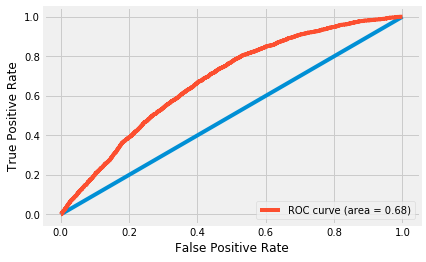

In [142]:
roc_auc = metrics.auc(fpr,tpr)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr,label=f'ROC curve (area = {roc_auc:.2f})')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

While the curve suggests a modest improvement over random guessing of goal/no goal (i.e., it's to the left of the blue line), performance of the model does not appear particularly robust.

Plotting a **Calibration Curve** to investigate model reliability.

In [143]:
prob_true, prob_pred = calibration_curve(testy,proba,n_bins=20,strategy='quantile')

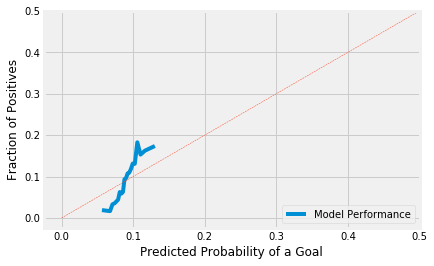

In [144]:
plt.plot(prob_pred, prob_true,label='Model Performance')
plt.plot([0,1],[0,1],linestyle='dashed',linewidth=0.5)
plt.legend(loc='lower right')
plt.xlim([-0.025,0.5])
plt.ylim([-0.025,0.5])
plt.xlabel('Predicted Probability of a Goal')
plt.ylabel('Fraction of Positives')
plt.show()

The reliability curve yields more evidence that our logistic regression is dominated by the goal frequency for all shots. Once the predicted probability increases beyond ~0.09, we see the model begins to underperform. Conversely, modeled probabilities less than ~0.09 show an overperformance when compared to the fraction of positives. Moreover, we notice that our model fails to predict many probabilities less than ~0.05 or greater than ~0.13. All told, this model appears not much more useful than randomly guessing one goal per every 10 shots.

#### Resampling to balance dataset

One method we can try to improve performance of logistic regression is to resample our data to balance the dataset (i.e., create the same number of goal/no-goal samples).

In this instance, we will drop 90% of the no-goal samples to create a distribution of about 5000 goals and 5000 no goals. We will then run through the same procedures as before.

In [201]:
dfUnderSample = df.drop(df[df['target'] == 0].sample(frac=.9,random_state=1).index)

In [202]:
X = dfUnderSample.drop(columns=['target','period','shotType','shooterHomeAway','goalie','shooter','play','shooterTeamScore',\
                    'goalieTeamScore','x','y'])
y = dfUnderSample['target']

In [203]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
trainX, testX, trainy, testy = train_test_split(X_scaled, y, test_size=0.5, random_state=2)

In [204]:
clf = LogisticRegressionCV(cv=5, random_state=0).fit(trainX, trainy)

In [149]:
clf.predict_proba(testX)

array([[0.32302332, 0.67697668],
       [0.99490966, 0.00509034],
       [0.13919994, 0.86080006],
       ...,
       [0.37951721, 0.62048279],
       [0.28834133, 0.71165867],
       [0.90132262, 0.09867738]])

Based on this score, we can already tell that the new model is much more aggressive in predicting goals, as it's only correct 64% of the time (if we reduce it to a goal/no goal prediction).

In [205]:
clf.score(testX,testy)

0.6440619022778648

Here, our balanced accuracy score suggests at least some increase in skill (relative to the model trained on the imbalanced dataset).

In [206]:
metrics.balanced_accuracy_score(testy,clf.predict(testX),adjusted=True)

0.2877098999350478

Sure enough, over half the samples are now predicted goals (> 50% probability of a goal).

In [151]:
proba = clf.predict_proba(testX)[:, 1]

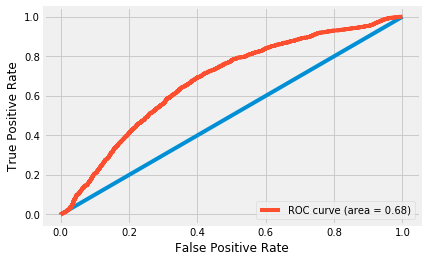

In [152]:
fpr, tpr, thresholds = metrics.roc_curve(testy,proba)
roc_auc = metrics.auc(fpr,tpr)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr,label=f'ROC curve (area = {roc_auc:.2f})')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [157]:
prob_true, prob_pred = calibration_curve(testy,proba,n_bins=20, strategy='quantile')

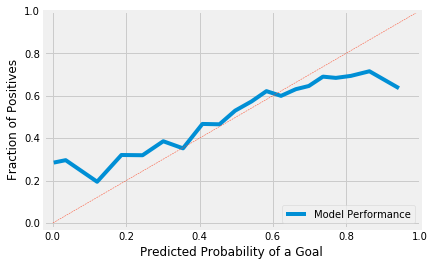

In [158]:
plt.plot(prob_pred, prob_true,label='Model Performance')
plt.plot([0,1],[0,1],linestyle='dashed',linewidth=0.5)
plt.legend(loc='lower right')
plt.xlim([-0.025,1])
plt.ylim([-0.025,1])
plt.xlabel('Predicted Probability of a Goal')
plt.ylabel('Fraction of Positives')
plt.show()

While our new logistic regression now appears to have a much broader distribution of predicted probabilities, we noticed earlier that its classification (calling either a goal or not) score is worse than the prior logistic regression model, which essentially predicts everything as no goal. Certainly, any model that predicts higher than a 50% probability of a goal for a particular shot is likely too confident, given that even the best players tend to have penalty shot/shootout percentages (one of the highest goal probability scenarios) no greater than 50%. So while we did improve the predictive range, it appears that re-sampling made the model too aggressive.

Additionally, it should be noted that the model was run on a test dataset that also is characterized by undersampling of no-goal shots. If we ran this model on the total distribution of samples, we'd likely see that the model overpredicts the number of goals.

### Gaussian NB

In [163]:
from sklearn.naive_bayes import GaussianNB

In [160]:
X = dfUnderSample.drop(columns=['target','period','shotType','shooterHomeAway','goalie','shooter','play','shooterTeamScore',\
                    'goalieTeamScore','x','y'])
y = dfUnderSample['target']

In [161]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
trainX, testX, trainy, testy = train_test_split(X_scaled, y, test_size=0.5, random_state=2)

In [164]:
# Gaussian NB with isotonic calibration
isotonic = CalibratedClassifierCV(GaussianNB(), cv=2, method='isotonic')
sigmoid = CalibratedClassifierCV(GaussianNB(), cv=2, method='sigmoid')

In [168]:
clf = isotonic.fit(trainX,trainy)

In [173]:
clf.score(testX,testy)

0.5341679707876891

In [169]:
# Calculate the probability of a goal using the test set
proba = clf.predict_proba(testX)[:,1]

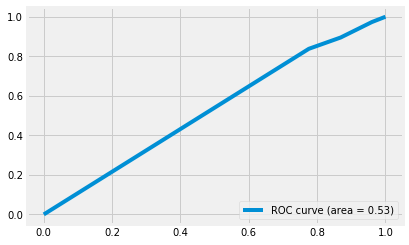

In [170]:
fpr, tpr, thresholds = metrics.roc_curve(testy,proba)
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr,tpr,label=f'ROC curve (area = {roc_auc:.2f})')
plt.legend(loc="lower right")

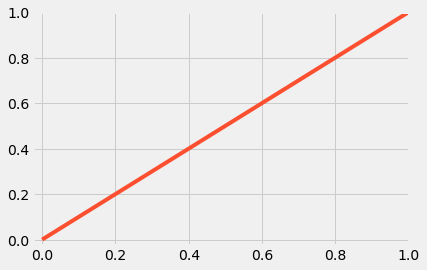

In [240]:
prob_true, prob_pred = calibration_curve(testy,proba,n_bins=10)
plt.plot(prob_pred, prob_true)
plt.plot([0,1],[0,1])
plt.xlim([-0.025,1])
plt.ylim([-0.025,1])
plt.show()

### Support Vector Machines

In [175]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [260]:
X = df.drop(columns=['target','period','shotType','shooterHomeAway','goalie','shooter','play','shooterTeamScore',\
                    'goalieTeamScore','x','y'])
y = df['target']

In [261]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
trainX, testX, trainy, testy = train_test_split(X_scaled, y, test_size=0.5, random_state=2)

##### Calibrating SGD model

In [262]:
model = SGDClassifier(random_state=2)
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)

In [263]:
calibrated.fit(trainX, trainy)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5, random_state=2,
                                                    shuffle=True, tol=0.001,
                                                    validation_fraction=0.1,
                

In [264]:
proba = calibrated.predict_proba(testX)[:, 1]

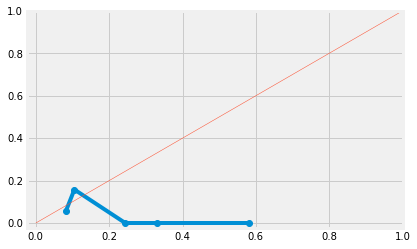

In [265]:
# reliability diagram
fop, mpv = calibration_curve(testy, proba, n_bins=10, normalize=False)
plt.plot(mpv, fop, marker='o')
plt.plot([0,1],[0,1],linewidth=0.5)
plt.xlim([-0.025,1])
plt.ylim([-0.025,1])
plt.show()

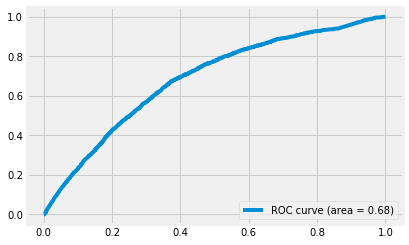

In [191]:
fpr, tpr, thresholds = metrics.roc_curve(testy,proba)
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr,tpr,label=f'ROC curve (area = {roc_auc:.2f})')
plt.legend(loc="lower right")

### Gradient Boosting

To head in a little different direction, let's try a non-linear, ensemble model.

In [70]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

As before, we'll create our feature and target data. However, with our ensemble decision-tree model, we'll re-introduce some of the variables that we were worried might cause collinearity issues with our logistic regression.

In [244]:
X = df.drop(columns=['target','period','shotType','shooterHomeAway','goalie','shooter','play'])
y = df['target']

In [245]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
trainX, testX, trainy, testy = train_test_split(X_scaled, y, test_size=0.5, random_state=2)

Create our gradient boosting classifier instance and pass it to another CV method; however, this method also produces calibrated probabilities from the classifier, since gradient boosting does not inherently provide calibrated probabilities.

In [246]:
model = GBC(random_state=2)
calibrated = CalibratedClassifierCV(model, cv=5)

In [247]:
calibrated.fit(trainX, trainy)

CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                                 criterion='friedman_mse',
                                                                 init=None,
                                                                 learning_rate=0.1,
                                                                 loss='deviance',
                                                                 max_depth=3,
                                                                 max_features=None,
                                                                 max_leaf_nodes=None,
                                                                 min_impurity_decrease=0.0,
                                                                 min_impurity_split=None,
                                                                 min_samples_leaf=1,
                                                                 min_sam

In [248]:
proba = calibrated.predict_proba(testX)[:, 1]

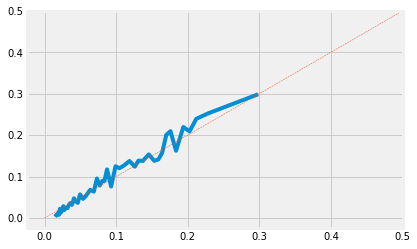

In [251]:
# reliability diagram
fop, mpv = calibration_curve(testy, proba, n_bins=50, strategy='quantile', normalize=False)
plt.plot(mpv, fop)
plt.plot([0,1],[0,1],linestyle='dashed',linewidth=0.5)
plt.xlim([-0.025,0.5])
plt.ylim([-0.025,0.5])
plt.show()

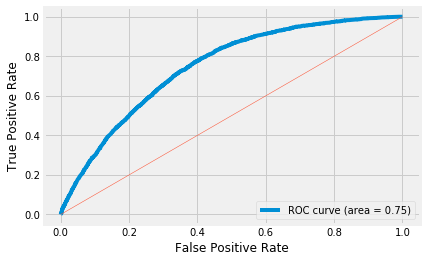

In [252]:
fpr, tpr, thresholds = metrics.roc_curve(testy,proba)
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr,tpr,label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],linewidth=0.5)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [226]:
calibrated.score(testX,testy)

0.908522134799507

Use joblib to persist the model and its associated scaler.

In [253]:
from joblib import dump, load

In [254]:
dump(calibrated, 'gbGoalie_2March2020.joblib')

['gbGoalie_2March2020.joblib']

In [255]:
dump(scaler, 'scaler.bin')

['scaler.bin']

StandardScaler(copy=True, with_mean=True, with_std=True)